In [1]:
# Part 1: Core Imports
# ================================
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import mediapipe as mp   # face detection (future expansion)
from skimage.metrics import structural_similarity as ssim   # similarity metrics
from tqdm import tqdm            # text-based progress bar (works everywhere)
import seaborn as sns            # for professional plots (optional)

plt.style.use("seaborn-v0_8")  # professional style


In [2]:
# Part 2: Frame Extraction Function
# ================================
def extract_multiple_videos(input_filename, image_path_infile):
    """Extract video file into sequence of images (frames)."""
    i = 1
    
    cap = cv2.VideoCapture(input_filename)
    if not cap.isOpened():
        print(f"❌ Error opening file: {input_filename}")
        return
    
    os.makedirs(image_path_infile, exist_ok=True)
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for _ in tqdm(range(total_frames), desc=f"Extracting {input_filename}"):
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(os.path.join(image_path_infile, f"{i}.jpg"), frame)
        i += 1
    
    cap.release()
    print(f"✅ Extracted {i-1} frames from {input_filename} into {image_path_infile}")




In [3]:
# Part 3: Extract Frames for Videos
# ================================
fake_image_path_for_frame = "frames_fake"
real_image_path_for_frame = "frames_real"

extract_multiple_videos("Fake.mp4", fake_image_path_for_frame)
extract_multiple_videos("Real.mp4", real_image_path_for_frame)


Extracting Fake.mp4: 100%|█████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 3016.68it/s]


✅ Extracted 297 frames from Fake.mp4 into frames_fake


Extracting Real.mp4: 100%|█████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 3184.16it/s]

✅ Extracted 297 frames from Real.mp4 into frames_real


In [4]:
# Part 4: Similarity Metrics
# ================================
def mse(imageA, imageB):
    """Compute the Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err  # lower = more similar

def compare_images(imageA, imageB):
    """Compare two images using MSE and SSIM."""
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    m = mse(grayA, grayB)
    s = ssim(grayA, grayB)
    return m, s

def plot_image_comparison(imageA, imageB, m, s, title="Comparison"):
    """Plot two images side by side with similarity metrics."""
    fig = plt.figure(title)
    plt.suptitle(f"MSE: {m:.2f}, SSIM: {s:.2f}")
    
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    ax.set_title("Image A")
    
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    ax.set_title("Image B")
    
    plt.show()


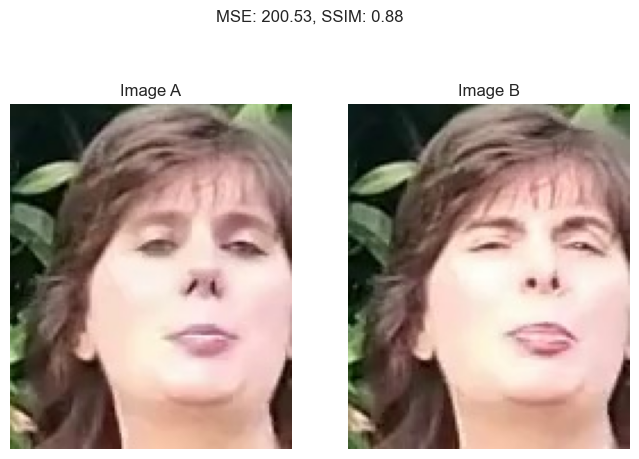

In [5]:
# Part 5: Test on First Frame
# ================================
imgA = cv2.imread("frames_fake/1.jpg")
imgB = cv2.imread("frames_real/1.jpg")

m, s = compare_images(imgA, imgB)
plot_image_comparison(imgA, imgB, m, s, "Fake vs Real - Frame 1")


In [8]:
# Part 6: Compare All Frames & Save CSV
# ================================
results = []
num_frames = min(len(os.listdir(fake_image_path_for_frame)), len(os.listdir(real_image_path_for_frame)))

for i in tqdm(range(1, num_frames+1), desc="Comparing frames"):
    f_img = cv2.imread(f"{fake_image_path_for_frame}/{i}.jpg")
    r_img = cv2.imread(f"{real_image_path_for_frame}/{i}.jpg")
    
    if f_img is None or r_img is None:
        continue
    
    m, s = compare_images(f_img, r_img)
    results.append({"frame": i, "MSE": m, "SSIM": s})

df = pd.DataFrame(results)
df.to_csv("frame_comparison_results.csv", index=False)
print("✅ Results saved to frame_comparison_results.csv")


Comparing frames: 100%|█████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 930.39it/s]

✅ Results saved to frame_comparison_results.csv


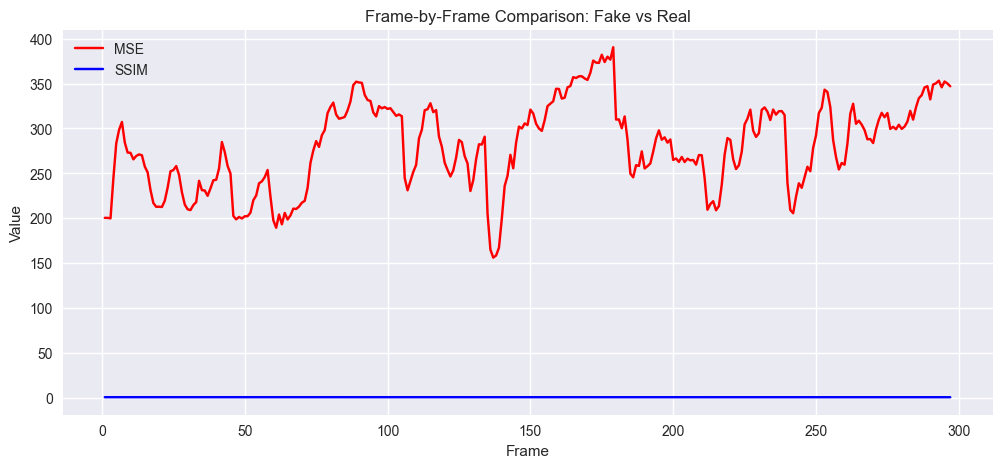

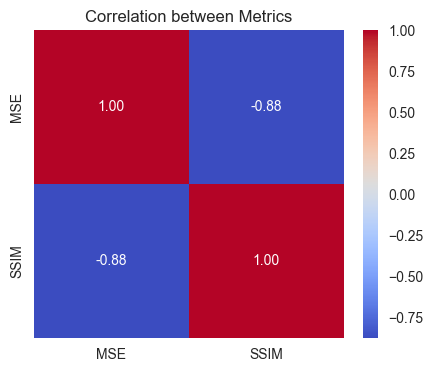

In [7]:
# Part 7: Visualization
# ================================
plt.figure(figsize=(12,5))
plt.plot(df["frame"], df["MSE"], label="MSE", color="red")
plt.plot(df["frame"], df["SSIM"], label="SSIM", color="blue")
plt.xlabel("Frame")
plt.ylabel("Value")
plt.title("Frame-by-Frame Comparison: Fake vs Real")
plt.legend()
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(df[["MSE", "SSIM"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Metrics")
plt.show()